# Прогнозирование температуры звезды

**Цель** - исследовать данные о температурах на поверхности звезды.

**Задача** - Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды. Метрика RMSE < 4500.

Согласно документации данные находятся в файле `6_class.csv `

**Описание признаков**
- `Относительная светимость L/Lo` — светимость звезды относительно Солнца.
- `Относительный радиус R/Ro` — радиус звезды относительно радиуса Солнца.
- `Абсолютная звёздная величина Mv` — физическая величина, характеризующая блеск звезды.
- `Звёздный цвет` (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- `Тип звезды`.
- `Абсолютная температура T(K)` — температура на поверхности звезды в Кельвинах.

**План исследования**
1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных к построению модели
5. Построение базовой нейронной сети
6. Улучшение нейронной сети
7. Общий вывод

## Изученние даных
### Импорт библиотек

In [1]:
import os
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import statsmodels.api as sm

In [2]:
%matplotlib inline
torch.use_deterministic_algorithms(True)
pd.options.mode.chained_assignment = None

### Функции

In [3]:
def test_shapiro(data, alpha):
    '''
    Функция проверяет данные на нормальное
    распределени, используя тест Шапиро-Уилка и
    строит график QQ-plot. Принимает столбец и 
    сверяет его p-value с уровнем статистической 
    значимости, выводит ответ о нормальности и график.
    '''

    stat, p = shapiro(data)

    if p > alpha:
        print('Не отвергаем H0. Данные получены из нормального распределения')
    else:
        print('Отвегаем H0 и принимаем H1. \
Данные не получены из нормального распределения')

    sm.qqplot(data, line='s')
    plt.title(f'QQ-plot {data.name}')

### Константы

In [4]:
ALPHA = 0.05 
RANDOM_STATE = 42 
TEST_SIZE = 0.25

### Загрузка данных

Сохарним датасет в переменную `star_df`

In [5]:
pth = '/datasets/6_class.csv'

In [6]:
if os.path.exists(pth):
    star_df = pd.read_csv(pth, sep=',', index_col=0)
else:
    print('Файл не найден')

In [7]:
star_df.shape

(240, 6)

Изучим данные. Выведем первые 5 строк, полную информацию и описательную статистику датасета.

In [8]:
star_df.head()  # Смотрим на первые 5 строк

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [9]:
star_df.info()  # Выводим полную информацию

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [10]:
star_df.describe()  # Выводим описательную статистику

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Рассмотрим полученную информацию.

Всего в таблице 6 столбцов, тип данных - `float`(3), `int`(2) и `object`(1). Количество значений в столбцах одинаковое, а вероятно пропусков нет.

Исходя из описательной статистики можно заметить, что у признаков сильно отличается значение медианы и среднего. Возможно два варианта либо же в данных присутствуют выбросы, либо же данные просто не стандартизированы. 

Возможно, стоит изменить тип данных для экономии памяти. А также привести два столбца к типу `category`.

### Вывод

Каждая строка таблицы содержит информацию об изученных звездах. Что необходимо будет сделать:

- Изменить тип данных для экономии памяти. А также привести два столбца к типу `category`.
- Изменить названия столбцов: `Temperature (K)`, `Absolute magnitude(Mv)`, `Star type` и `Star color`
- Еще раз проверить данные на наличие пропусков.
- Сделать проверку на явные и неявные дубликаты.
- При исследовательском анализе более пристальное внимание уделить выбросам.

## Предобработка данных
### Изменение типов данных

Изменим тип данных на более экономичный вариант, а также столбцы `Star color` и `Star type` приведем к типу `category`.

In [11]:
# Меняем типы данных
star_df['Temperature (K)'] = star_df['Temperature (K)'].astype('int32')
star_df['Luminosity(L/Lo)'] = star_df['Luminosity(L/Lo)'].astype('float32')
star_df['Radius(R/Ro)'] = star_df['Radius(R/Ro)'].astype('float32')
star_df['Absolute magnitude(Mv)'] = star_df['Absolute magnitude(Mv)'].astype(
    'float32')
star_df['Star color'] = star_df['Star color'].astype('category')
star_df['Star type'] = star_df['Star type'].astype('category')

### Изменение названия столбцов

Изменим названия столбцов для более удобно обращения к ним в последующем.

In [13]:
# Меняем названия столбцов
star_df = star_df.rename(columns={'Temperature (K)': 'temperature',
                                  'Absolute magnitude(Mv)': 'magnitude',
                                  'Star type': 'type', 'Star color': 'color',
                                  'Radius(R/Ro)': 'radius', 'Luminosity(L/Lo)': 'luminosity'})

Проверим результаты изменений

In [14]:
star_df.columns  # Выводим названия столбцов

Index(['temperature', 'luminosity', 'radius', 'magnitude', 'type', 'color'], dtype='object')

In [15]:
star_df.dtypes  # Выводим типы данных

temperature       int32
luminosity      float32
radius          float32
magnitude       float32
type           category
color          category
dtype: object

### Работа с пропусками

Хоть первичная проверка при изучении данных показала, что пропусков нет. На всякий случай еще раз проверим.

In [16]:
# Считаем количество пропусков
count_na = pd.Series(star_df.isna().sum(), name='Пропуски')

In [17]:
# Считаем долю пропусков
proportion_na = pd.Series(
    (star_df.isna().sum() / len(star_df)).round(4) * 100, name='Доля')

In [18]:
# Выводим таблицу с пропусками
pd.concat([count_na, proportion_na], axis=1)

,Пропуски,Доля
temperature,0,0.0
luminosity,0,0.0
radius,0,0.0
magnitude,0,0.0
type,0,0.0
color,0,0.0


Пропусков не обнаружено

### Работа с явными дубликатами

In [19]:
star_df.duplicated().sum()  # Проверяем наличие явных дубликатов

0

Явных дубликатов не обнаружено

### Работа с неявными дубликатами

Необходимо проверить столбцы `type` и `color`, так как в этих столбцах возможны ошибки в написании категорий. (одно и то же значение может быть написано по-разному)

In [20]:
# Выводим количество уникальных значений
types = star_df['type'].value_counts()
types

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

Все соответствует  документации. Неявных дубликатов не обнаружено.

In [21]:
star_df['color'].value_counts()  # Выводим количество уникальных значений

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
yellowish               2
Orange                  2
Blue                    1
White-Yellow            1
Orange-Red              1
Yellowish               1
Blue-White              1
Blue white              1
Pale yellow orange      1
Name: color, dtype: int64

Видно, что один и тот же цвет записан по-разному. Необходимо это исправить

Для начала приведем все названия к одному регистру и удалим пробелы в начале и конце.

In [22]:
star_df['color'] = star_df['color'].str.lower().str.strip()

In [23]:
star_df['color'].value_counts()

red                   112
blue                   56
blue-white             27
blue white             14
white                  10
yellow-white            8
yellowish               3
yellowish white         3
whitish                 2
orange                  2
white-yellow            1
pale yellow orange      1
orange-red              1
Name: color, dtype: int64

Остальные значение придется изменять вручную. Множество вариантов написания `blue-white` и `yellow-white`.

In [24]:
# Создаем список кортежей для замены
replace_val = [('blue white', 'blue-white'), ('white-yellow', 'yellow-white')]

In [25]:
star_df['color'] = star_df['color'].replace(replace_val)  # Заменяем значения

In [26]:
star_df['color'].value_counts()  # Делаем проверку

red                   115
blue                   77
white                  26
whitish                 7
yellowish               5
yellowish white         4
orange-red              3
orange                  2
pale yellow orange      1
Name: color, dtype: int64

Видно, что звезд цветов pale yellow orange, orange и orange-red очень мало и их можно объединить в один цвет `orange`.

In [27]:
# Создаем словарь для замены
replace_orange = {'pale yellow orange': 'orange', 'orange-red': 'orange'}

In [28]:
star_df['color'] = star_df['color'].replace(
    replace_orange)  # Заменяем значения

In [29]:
color = star_df['color'].value_counts()  # Делаем проверку
color

red                115
blue                77
white               26
whitish              7
orange               6
yellowish            5
yellowish white      4
Name: color, dtype: int64

Неявные дубликаты исправлены.

### Вывод

На данном этапе были сделаны следующие действия:
- Изменили тип данных в столбцах для экономичного управления памятью
- Изменили тип данных в столбцах `color` и `type` на `category`
- Изменили названия столбцов для удобства
- Сделали проверку на пропуски в данных. В результате не обнаружены.
- Сделали проверку на явные дубликаты. В результате не обнаружены.
- Сделали проверку на неявные дубликаты и исправили. Были найдены несколько неявных дубликатов в цветах звезд. Привели цвета к нижнему регистру и удалили пробелы, тем самым исправили часть дубликатов. Затем пришлось изменить несколько названий одних и тех же цветов. 
    - `blue white` на `blue-white`.
    - `white-yellow` на `yellow-white`.
- Цвета pale yellow orange, orange и orange-red объединили в один цвет `orange` из-за малого количества их по отдельности.

## Исследовательский анализ данных

Исследуем данные в датафрейме.
- Исследуем категориальные данные. Построим гистограмму и круговую диаграмму для визуализации количества категорий.
- Исследуем количественные данные. Построим диаграммы рассеяния для изучения выбросов и гистограмму для изучения распределений.

### Категориальные данные

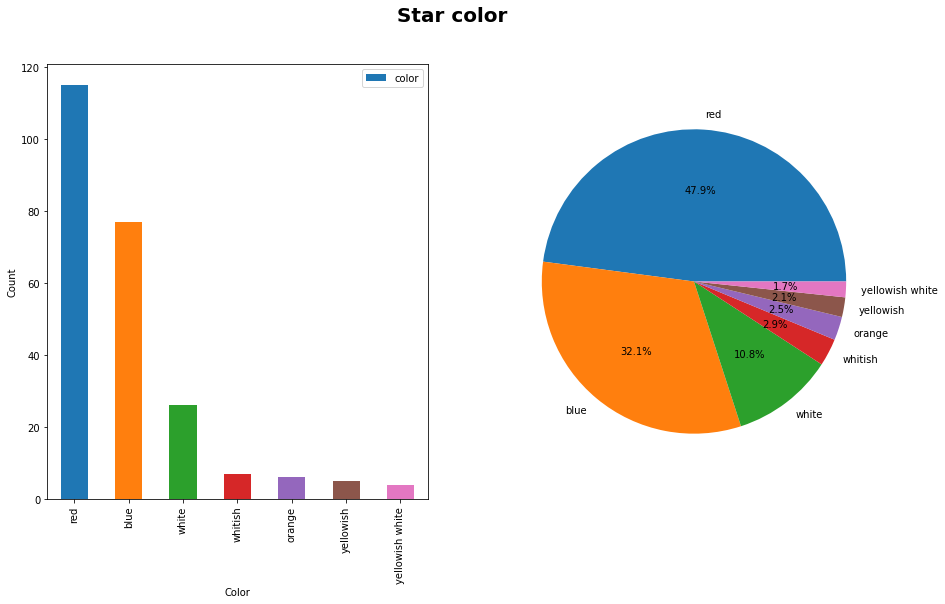

In [30]:
# Строим plot и pie
plt.figure(figsize=(15, 8))

plt.suptitle('Star color', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
color.plot(kind='bar', color=mcolors.TABLEAU_COLORS)
plt.legend()
plt.xlabel('Color')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(color.values, labels=color.index, autopct='%.1f%%');

В данных преобладают звезды трех цветов: `red` - 47.9%, `blue` - 32.1% и `white` - 10.8%. Первые два цвета составляют 80% данных. Все остальные цвета незначительные. Самые редкие цвета - `yellowish white` - 1.7%, `yellowish` - 2.1% и `orange` - 2.5%.

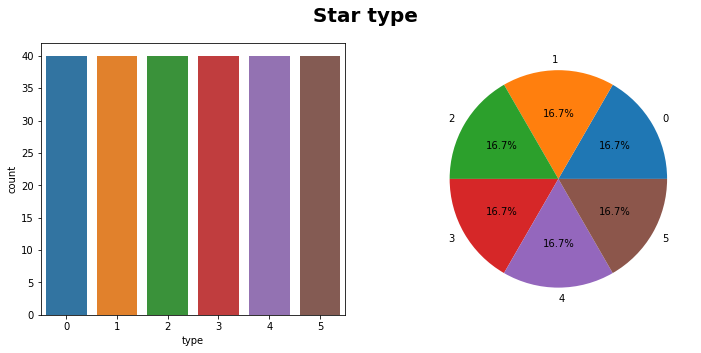

In [31]:
# Строим plot и pie
plt.figure(figsize=(12, 5))

plt.suptitle('Star type', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
sns.countplot(x='type', data=star_df)

plt.subplot(1, 2, 2)
plt.pie(types.values, labels=types.index, autopct='%.1f%%');

В данных есть 5 типов звезд они имеют одинаковое соотношение между собой, что и показывают графики.

### Количественные данные

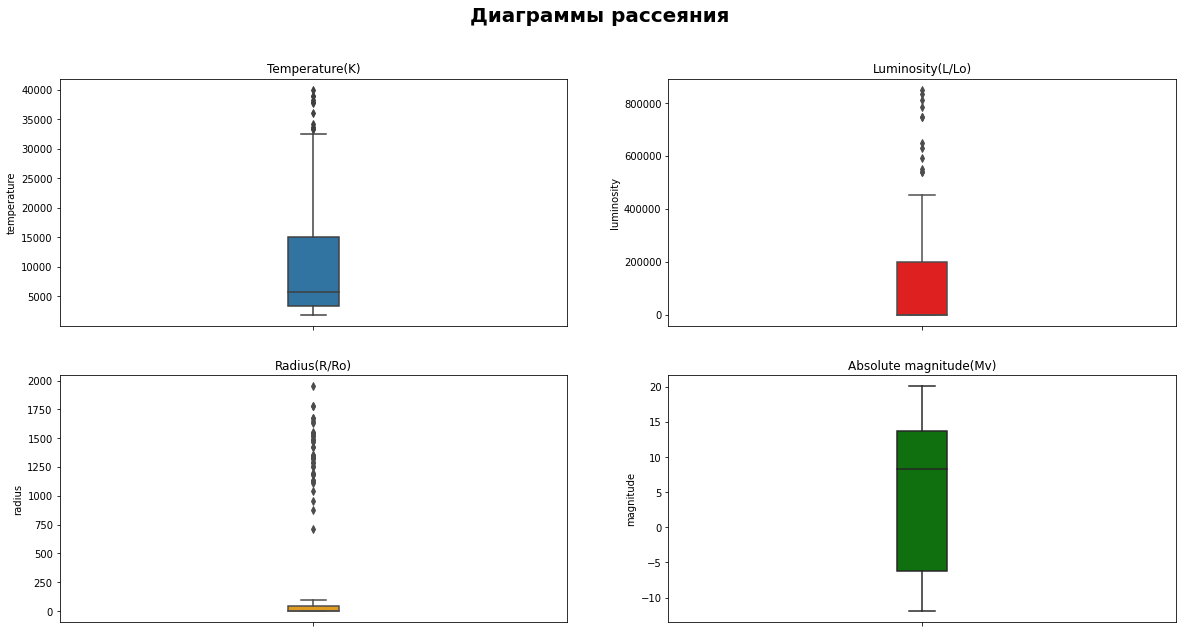

In [32]:
# Строим boxplot
plt.figure(figsize=(20, 10))

plt.suptitle('Диаграммы рассеяния', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(y=star_df['temperature'], width=.1)
plt.title('Temperature(K)')

plt.subplot(2, 2, 2)
sns.boxplot(y=star_df['luminosity'], width=.1, color='red')
plt.title('Luminosity(L/Lo)')

plt.subplot(2, 2, 3)
sns.boxplot(y=star_df['radius'], width=.1, color='orange')
plt.title('Radius(R/Ro)')

plt.subplot(2, 2, 4)
sns.boxplot(y=star_df['magnitude'], width=.1, color='green')
plt.title('Absolute magnitude(Mv)');

Как видно из графиков `boxplot` в трех столбцах есть выбивающиеся значения. Посмотрим на эти значения по-другому. Построим pairplot для детально просмотра данных, возможно, получиться выделить какие-нибудь новые категории.


<Figure size 1440x720 with 0 Axes>

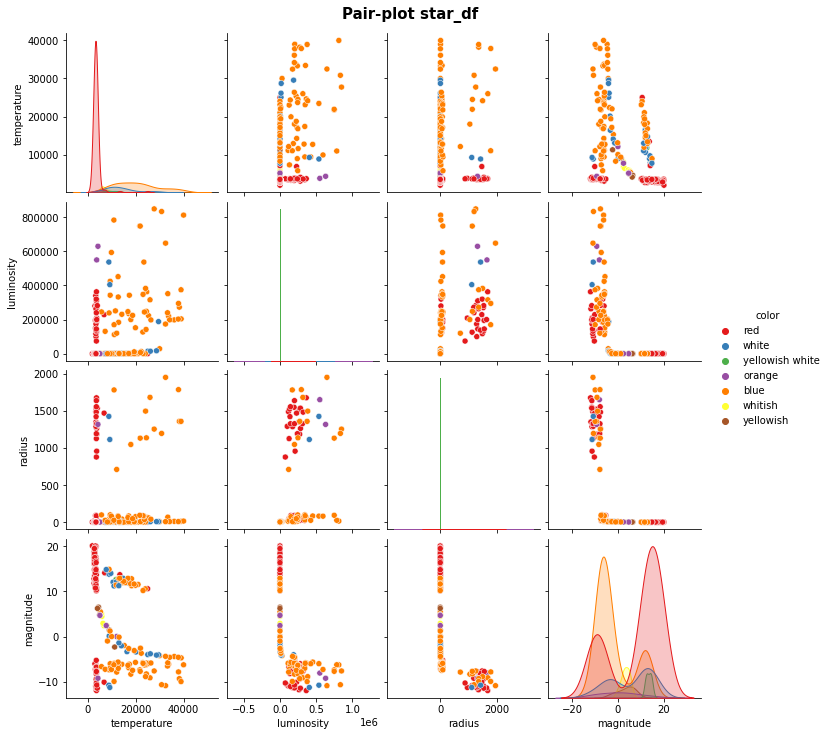

In [36]:
plt.figure(figsize=(20, 10))
sns.pairplot(star_df, hue='color', palette='Set1')
plt.suptitle('Pair-plot star_df', fontsize=15, fontweight='bold', y=1.02)
plt.show();

По графику pairplot хорошо заметно, что радиус и светимость, можно разбить кластеры, чтобы создать новые столбцы. Также можно отметить, что чем выше температура, тем меньше абсолютная магнитуда звезды. Такой же вывод можно сделать и для радиуса, чем он больше, тем меньше магнитуда.

Теперь построим гистограммы распределений.

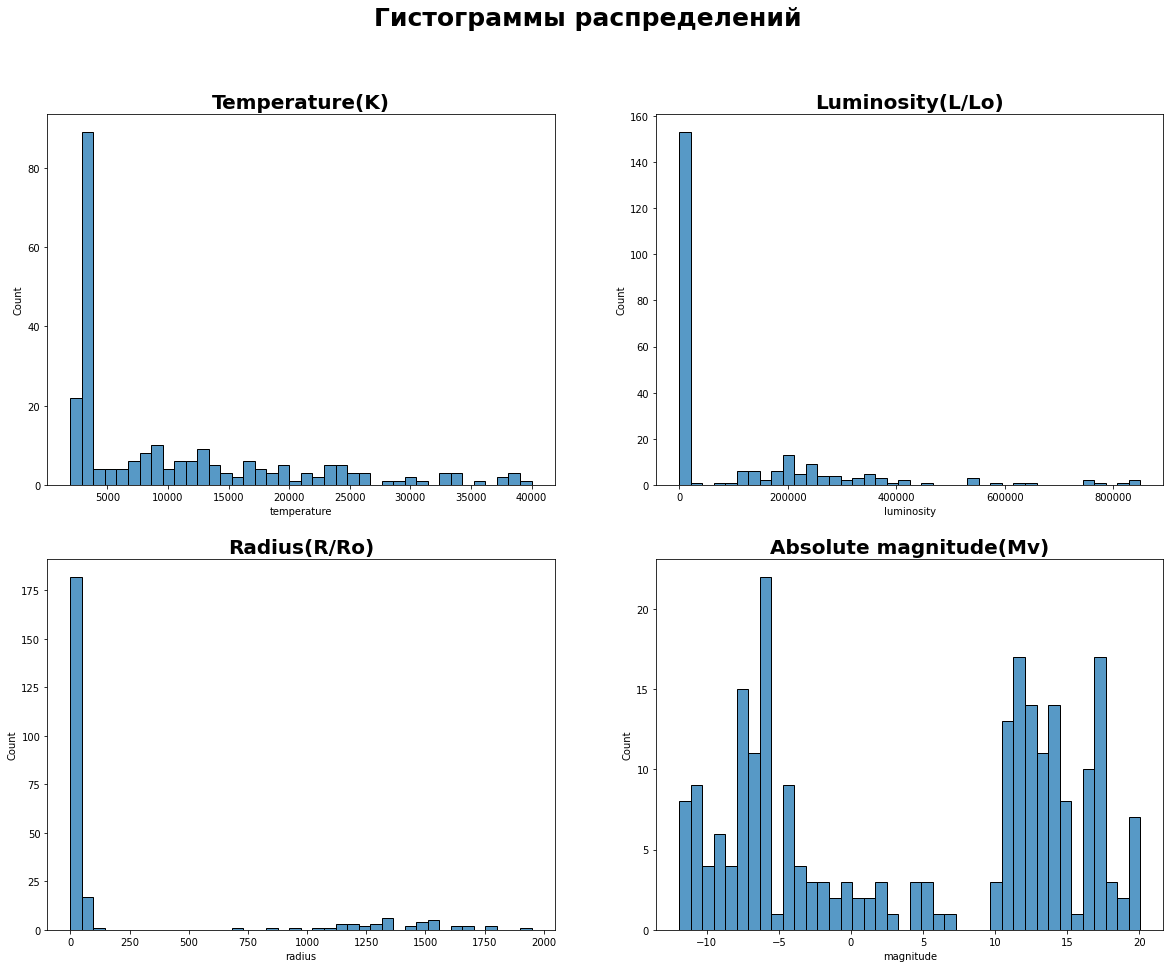

In [37]:
plt.figure(figsize=(20, 15))

plt.suptitle('Гистограммы распределений', fontsize=25, fontweight='bold')

plt.subplot(2, 2, 1)
sns.histplot(star_df['temperature'], bins=40)
plt.title('Temperature(K)', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 2)
sns.histplot(star_df['luminosity'], bins=40)
plt.title('Luminosity(L/Lo)', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 3)
sns.histplot(star_df['radius'], bins=40)
plt.title('Radius(R/Ro)', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 4)
sns.histplot(star_df['magnitude'], bins=40)
plt.title('Absolute magnitude(Mv)', fontsize=20, fontweight='bold');

Как можно увидеть из графиков данные распределены ненормально. Здесь также хорошо видны, как можно создать категории на их основе.

Хоть визуально и видно, что данные распределены ненормально стоит все же провести статистический тест, а также построить график QQ-plot. Воспользуемся тестом Шапиро-Уилка, чтобы определить нормально ли распределены у нас данные.

Необходимо сформулировать гипотезы:
- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Для проведения теста была написана функция `test_shapiro`. Пусть верна нулевая гипотеза, тогда:

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


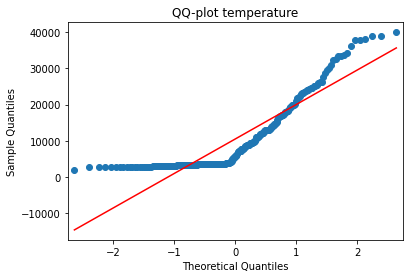

In [38]:
test_shapiro(star_df['temperature'], ALPHA)

Пресутсвуют  отклонения около 0 и в крайних частях графика (положительные и отрицательные квантили), что может указывать на наличие выбросов или особую структуру данных в этих областях.

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


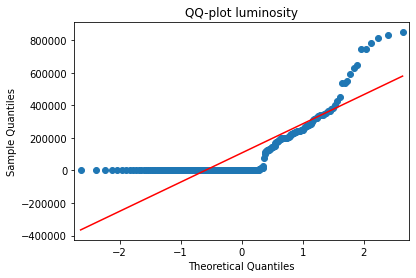

In [39]:
test_shapiro(star_df['luminosity'], ALPHA)

В районе около 0, данные имеют горизонтальное распределение, что указывает на наличие большого количества значений, равных нулю или близких к нему. (Гистограмма выше это подтверждает) Это означает, что распределение данных здесь сильно отличается от нормального, и, вероятно, имеет большое количество одинаковых или почти одинаковых значений. Таким образом, данные существенно отклоняются от нормального распределения, особенно в области, близкой к нулю. Это свидетельствует о наличии большого количества одинаковых значений и выбросов в данных.

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


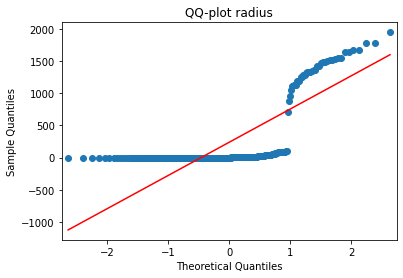

In [40]:
test_shapiro(star_df['radius'], ALPHA)

График показывает, что распределение данных отличается от нормального, особенно в положительных квантилях. Это может указывать на наличие выбросов или на то, что данные имеют распределение с тяжелым хвостом (что и подтверждала гистограмма)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


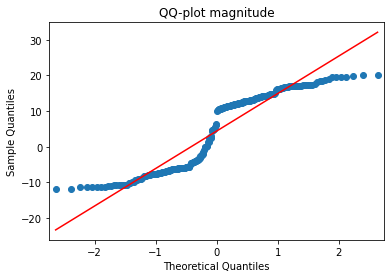

In [41]:
test_shapiro(star_df['magnitude'], ALPHA)

Как и ожидалось, наши данные распределены ненормально, зато теперь мы доказали это не только визуально.

### Вывод

Провели исследовательский анализ категориальных и количественных данных.

- Для категориальных данных (цвет и тип):

В данных преобладают звезды трех цветов: `red` - 47.9%, `blue` - 32.1% и `white` - 10.8%. Первые два цвета составляют 80% данных. Все остальные цвета незначительные. Самые редкие цвета - `yellowish white` - 1.7%, `yellowish` - 2.1% и `orange` - 2.5%.

По типу звезд данные имеют одинаковое соотношение - 16.7%

- Для количественных данных:

Необходимо было сделать упор на редкие выбивающиеся значения, так как по описательной статистике стало заметно, что в данных они присутствуют. В трех столбцах такие значения были найдены. В результате для каждого из столбца был проведен более детальный анализ. По итогу все выбивающиеся значения не посчитали аномальными, так как эти редкие значения соответствуют редким звездам (огромным, ярким и т.п.) и такие звезды меньше изучены, отсюда и редкость. Также стоит отметить, что на основе столбцов `radius` и `luminosity` можно создать новые категории, так как данные очень хорошо распределены на отдельные кластеры, что подтверждается графиком pairplot. Все количественные признаки распределены ненормально, что также было проверено с помощью статистического теста Шапиро-Уилка и графика QQ-plot.

## Подготовка данных к построению модели

Создадим на основе столбца `radius` новый столбец, который будет включать в себя категории, если радиус < 250 то это будет `small` в противном случае `large`.

In [47]:
# Создаем новый столбец
star_df['radius_cat'] = (
    star_df['radius']
    .where(star_df['radius'] <= 250, 'large')
    .where(star_df['radius'] > 250, 'small'))

In [48]:
star_df['radius_cat'].value_counts()  # Проверка

small    200
large     40
Name: radius_cat, dtype: int64

И также создадим на основе столбца `luminosity` новый столбец, который будет включать в себя категории, если светимость < 100000 то это будет `faintly bright`, больше 500000 то `Very bright` и в противном случае `bright`.

In [49]:
# Создаем новый столбец
star_df['luminosity_cat'] = (
    star_df['luminosity']
    .where(star_df['luminosity'] >= 100000, 'faintly bright')
    .where(star_df['luminosity'] < 100000, 'bright')
    .where(star_df['luminosity'] <= 500000, 'Very bright')
)

In [50]:
star_df['luminosity_cat'].value_counts() # Проверка

faintly bright    155
bright             73
Very bright        12
Name: luminosity_cat, dtype: int64

Создадим новые столбцы за основу возьмем метод `pd.factorize` и объединим радиус, светимость и магнитуды с типом звезды и ее цветом. В результате у нас получиться 6 новых признаков.

In [51]:
# Создаем новые столбцы
star_df['luminosity_type'] = pd.factorize((star_df['luminosity'].astype('str') +
                                           star_df['type'].astype('str')).to_numpy())[0]

star_df['luminosity_color'] = pd.factorize((star_df['luminosity'].astype('str') +
                                            star_df['color'].astype('str')).to_numpy())[0]

star_df['radius_type'] = pd.factorize((star_df['radius'].astype('str') +
                                       star_df['type'].astype('str')).to_numpy())[0]

star_df['radius_color'] = pd.factorize((star_df['radius'].astype('str') +
                                        star_df['color'].astype('str')).to_numpy())[0]

star_df['magnitude_type'] = pd.factorize((star_df['magnitude'].astype('str') +
                                          star_df['type'].astype('str')).to_numpy())[0]

star_df['magnitude_color'] = pd.factorize((star_df['magnitude'].astype('str') +
                                           star_df['color'].astype('str')).to_numpy())[0]

Посмотрим на новые столбцы.

In [52]:
# Проверяем новые столбцы
star_df[['luminosity_type', 'luminosity_color', 'radius_type',
         'radius_color', 'magnitude_type', 'magnitude_color']]

,luminosity_type,luminosity_color,radius_type,radius_color,magnitude_type,magnitude_color
0,0,0,0,0,0,0
1,1,1,1,1,1,1
2,2,2,2,2,2,2
3,3,3,3,3,3,3
4,4,4,4,4,4,4
...,...,...,...,...,...,...
235,223,220,209,210,227,230
236,224,221,213,214,228,231
237,225,222,214,215,229,232
238,226,223,215,216,230,233


Прологарифмируем наши количественные столбцы и также создадим на их основе новые столбцы. Для того чтобы внести в наши данные нелинейность, так как логарифмическая функция является нелинейной, и применение её к признакам трансформирует их распределение, что может помочь в улучшении качества моделей. Для магнитуды возьмем значения по модулю, так как в нем пресутсвуют отрицательные значения, а следовательно логарифм взять не получить

In [53]:
# Логарифмируем количественные признаки и сохраняем их в датафрейме
star_df['radius_log'] = star_df['radius'].apply(lambda x: np.log(x))
star_df['luminosity_log'] = star_df['luminosity'].apply(lambda x: np.log(x))
star_df['magnitude_log'] = star_df['magnitude'].apply(lambda x: np.log(abs(x)))

*p.s. Для того чтобы удовлетворять условию задачи, пришлось создавать много новых признаков*

Подготовим тренировчную и тестовую выборки. Наш целевой признак - `temperature`

In [54]:
X = star_df.drop(columns=['temperature'], axis=1)
y = star_df['temperature']

Проверим не появились ли дубилкаты

In [55]:
X.duplicated().sum()  # Проверяем дубликаты

0

In [56]:
# Разделим данные на тренировчные и тестовые
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    shuffle=True
)

In [57]:
fact = y_test.copy()

Проверим правильно ли разбили данные

In [58]:
X_train.shape, y_train.shape  # Размерность тренировочной

((180, 16), (180,))

In [59]:
X_test.shape, y_test.shape  # Размерность тестовой

((60, 16), (60,))

Сделаем масштабирование данных

In [60]:
# Создаем список столбцов
num_columns = ['luminosity', 'radius', 'magnitude', 'radius_log', 'luminosity_log',
               'magnitude_log', 'luminosity_type', 'luminosity_color', 'radius_type',
               'radius_color', 'magnitude_type', 'magnitude_color']

In [61]:
scaler = StandardScaler()  # Инициализируем стандартизатор

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

Теперь необходимо закодировать категориальные признаки, для этого воспользуемся `OneHotEncoder`


In [62]:
# Создаем список категориальных столбцов
cat_columns = ['color', 'radius_cat', 'luminosity_cat', 'type']

In [63]:
# Инициализируем кодировщик
encoder = OneHotEncoder(drop='first', sparse=False)

X_train_ohe = encoder.fit_transform(X_train[cat_columns])
X_test_ohe = encoder.transform(X_test[cat_columns])

In [64]:
new_name = encoder.get_feature_names()  # Получаем новые названия столбцов

In [65]:
# Получаем индексы выборок
idx_train = X_train.index
idx_test = X_test.index

In [66]:
# Добавляем новые столбцы
X_train[new_name] = pd.DataFrame(
    X_train_ohe, columns=new_name, index=idx_train)
X_test[new_name] = pd.DataFrame(X_test_ohe, columns=new_name, index=idx_test)

In [67]:
# Удаляем незакодированные категориальные столбцы
X_train = X_train.drop(columns=cat_columns, axis=1)
X_test = X_test.drop(columns=cat_columns, axis=1)

Проверим результат

In [68]:
X_train.head()  # Выводим первые 5 строк

,luminosity,radius,magnitude,luminosity_type,luminosity_color,radius_type,radius_color,magnitude_type,magnitude_color,radius_log,...,x0_yellowish,x0_yellowish white,x1_small,x2_bright,x2_faintly bright,x3_1,x3_2,x3_3,x3_4,x3_5
95,-0.590699,-0.427420,-0.651610,-0.258168,-0.243879,-0.211378,-0.211535,-0.267728,-0.288593,0.331521,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
126,-0.594615,-0.441198,1.183989,0.193151,0.211269,0.168277,0.167580,0.193283,0.166548,-0.775897,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
120,-0.594615,-0.441202,1.210786,0.099774,0.117100,0.135264,0.134613,0.101081,0.075520,-0.781463,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67,-0.594615,-0.441203,1.142836,-0.693925,-0.683333,-0.624048,-0.623616,-0.698005,-0.713391,-0.781744,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101,4.142061,-0.413374,-1.027726,-0.164792,-0.149711,-0.112338,-0.112636,-0.175526,-0.197565,0.510103,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [69]:
X_test.head()  # Выводим первые 5 строк

,luminosity,radius,magnitude,luminosity_type,luminosity_color,radius_type,radius_color,magnitude_type,magnitude_color,radius_log,...,x0_yellowish,x0_yellowish white,x1_small,x2_bright,x2_faintly bright,x3_1,x3_2,x3_3,x3_4,x3_5
24,-0.594614,-0.441357,0.706427,-1.316434,-1.295430,-1.317333,-1.332396,-1.358788,-1.365760,-1.262294,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,-0.594615,-0.441131,1.216528,-1.596563,-1.562241,-1.597948,-1.596129,-1.635395,-1.638844,-0.696500,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
93,-0.594612,-0.439124,0.025973,-0.289294,-0.275269,-0.244392,-0.244502,-0.298462,-0.318936,-0.135669,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
109,1.456197,-0.307335,-0.985616,-0.055853,-0.024153,-0.013297,-0.013736,-0.052589,-0.076194,0.911816,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
104,0.057916,-0.417376,-0.997100,-0.118104,-0.102626,-0.128845,-0.129119,-0.129425,-0.152051,0.470551,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
X_train.shape  # Размерность тренировочной

(180, 26)

In [71]:
X_test.shape  # Размерность тестовой

(60, 26)

In [72]:
# Переведем данные в тензор
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Приступим к построению базовой нейронной сети.

## Построение базовой нейронной сети

Начнем с базовой нейронной сети с 2 скрытыми слоями. Функция активации `ReLU`. Оценивать модель будем по метрике `RMSE`. Целевой признак температура (столбец `temperature`)

*p.s. Использовал только ReLU, так как с другими функциями активации результаты были хуже.*

In [73]:
# Класс архетиктуры нейронной сети
class StarNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(StarNet, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)

        out = self.fc2(out)
        out = self.act2(out)

        out = self.fc3(out)
        return out

In [74]:
def baseline(*args):
    '''
    Функция для обучения нейронной сети. На вход получает
    12 аргументов (количество нейронов, скорость обучения и выборки)
    Считает RMSE на тестовой выборке и выводи предсказания.
    '''

    model = StarNet(n_in_neurons, n_hidden_neurons_1,
                    n_hidden_neurons_2, n_out_neurons)  # Вызываем класс

    loss = nn.MSELoss()  # В качестве функции потерь используем MSE
    # Создаем Adam оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Цикл обучения
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()  # Обнуление градиентов

        preds = model.forward(X_train).flatten()  # Прямое распространение
        # Берем корень от MSE, чтобы получить RMSE
        loss_value = torch.sqrt(loss(preds, y_train))

        loss_value.backward()
        optimizer.step()

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            model.eval()
            test_preds = model.forward(X_test)
            RMSE = torch.sqrt(torch.mean((test_preds-y_test)**2)
                              ).float().data  # Считаем RMSE
            print(
                'Эпоха [{}/{}], Значение RMSE: {:.4f}'.format(epoch, num_epochs, RMSE))

    return test_preds

Отдельно зададим параметры базовой нейронной сети

In [75]:
# Задаем параметры нейронной сети
n_in_neurons = 26
n_hidden_neurons_1 = 27
n_hidden_neurons_2 = 13
n_out_neurons = 1
learning_rate = 0.01
num_epochs = 1000

Начнем обучение

In [76]:
# Вызваем функцию обучения нейронной сети
preds = baseline(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,
                 n_out_neurons, learning_rate, X_train, X_test, y_train, y_test, num_epochs)

Эпоха [0/1000], Значение RMSE: 14626.6650
Эпоха [100/1000], Значение RMSE: 13450.3730
Эпоха [200/1000], Значение RMSE: 11818.3916
Эпоха [300/1000], Значение RMSE: 11940.0117
Эпоха [400/1000], Значение RMSE: 12229.2617
Эпоха [500/1000], Значение RMSE: 12461.2559
Эпоха [600/1000], Значение RMSE: 12635.1133
Эпоха [700/1000], Значение RMSE: 12756.9180
Эпоха [800/1000], Значение RMSE: 12853.4092
Эпоха [900/1000], Значение RMSE: 12987.9629
Эпоха [999/1000], Значение RMSE: 13167.8057


После обучения необходимо построить график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

In [77]:
fact_pred = pd.DataFrame(fact)  # Создаем датафрейм с фактическими данными

In [78]:
fact_pred['Прогноз'] = preds.detach().numpy()  # Создаем столбец прогноза

In [79]:
# Переименновываем столбец
fact_pred = fact_pred.rename(columns={'temperature': 'Факт'})

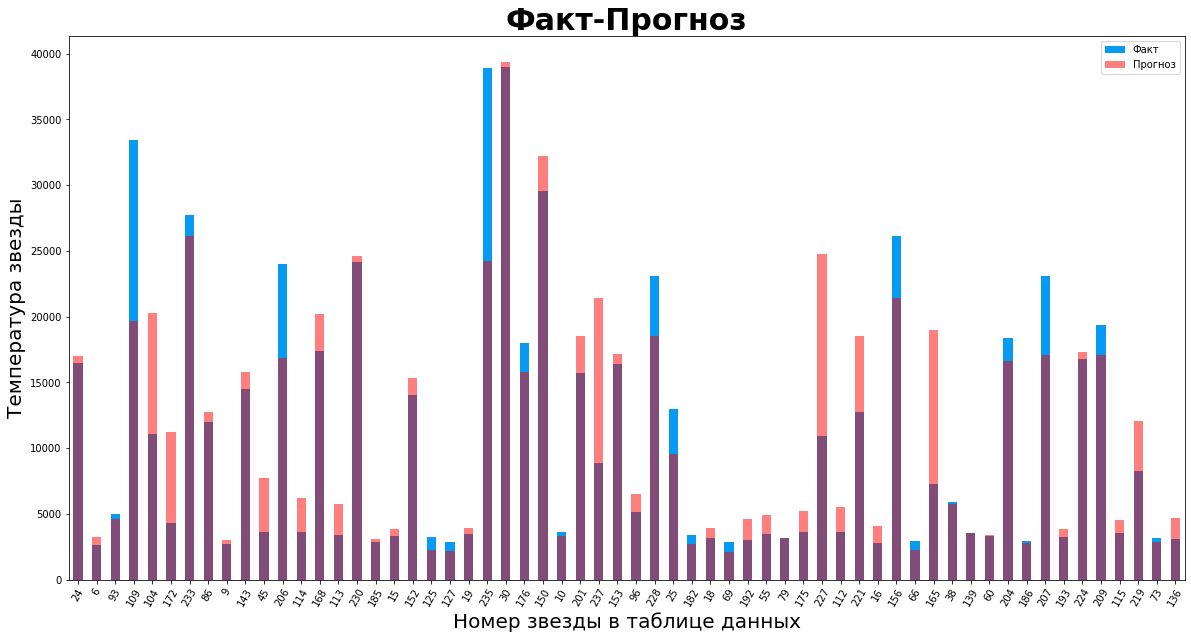

In [80]:
# Создаем график факт-прогноз
plt.figure(figsize=(20, 10))
fact_pred['Факт'].plot(kind='bar', color='#069AF3')
fact_pred['Прогноз'].plot(kind='bar', color='red', alpha=0.5)
plt.legend(frameon=True)
plt.xticks(rotation=60)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды', fontsize=20)
plt.title('Факт-Прогноз', fontsize=30, fontweight='bold');

Ясно, что результаты модели не являются удовлетворительными и приходим к выводу, что необходимо улучшить нашу базовую модель.

## Улучшение нейронной сети

Постараемся улучшить нейронную сеть при помощи перебора параметров нейросети. Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставим как в Baseline, чтобы в дальнейшим сравнить их. Параметры для перебора:
- Размер батча
- Dropout

Создадим новый класс архитектуры нейронной сети. А также напишем две функции для обучения модели и для оценки модели на тестовой выборке. 
Метрика все такая же. Необходимо, чтобы `RMSE` < 4500.

In [81]:
# Класс архетиктуры нейронной сети
class StarNetImproved(nn.Module):
    def __init__(self, dropout_rate, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(StarNetImproved, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        out = self.dp1(out)

        out = self.fc2(out)
        out = torch.relu(out)
        out = self.dp2(out)

        out = self.fc3(out)
        return out

In [82]:
def train(model, optimizer, loss, train_loader, epochs):
    '''
    Функция обучения нейронной сети. На вход получает модель,
    оптимизатор, функцию потерь, количество эпох и датасет.
    '''

    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch).flatten()
            loss_value = torch.sqrt(loss(preds, y_batch))
            loss_value.backward()
            optimizer.step()

In [83]:
def preds_test_rmse(model, test_loader):
    '''
    Функция для оценки модели на тестовых данных
    при помощи метрики RMSE. На вход получает модель и
    тестовые данные. На выходе функции значение метрики RMSE
    и предсказанные значения.
    '''

    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            y_pred.extend(preds.numpy().flatten())
            y_true.extend(y_batch.numpy())
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    rmse = torch.sqrt(torch.mean((y_pred - y_true) ** 2))
    return rmse.item(), y_pred

Приступим к перебору параметров для нейронной сети.

In [84]:
# Сохраняем время начала работы
start_time = time.time()

# Подготовка данных
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Перебор параметров
param_grid = {
    'batch_size': [10, 20, 40],
    'dropout_rate': [0.2, 0.4, 0.6],
}

best_rmse = float('inf')
best_params = {}

# Цикл перебора параметров
for batch_size in tqdm(param_grid['batch_size']):
    for dropout_rate in param_grid['dropout_rate']:
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size)

        model = StarNetImproved(
            dropout_rate, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
        loss = nn.MSELoss()  # Функция потерь
        optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate)  # Оптимизатор ADAM

        train(model, optimizer, loss, train_loader, num_epochs)
        rmse, test_preds = preds_test_rmse(model, test_loader)

        # Находим лучшую метрику и соотвествующие ей предсказания
        if rmse < best_rmse:
            best_rmse = rmse
            preds = test_preds
            best_params = {'batch_size': batch_size,
                           'dropout_rate': dropout_rate}

print(f"Лучший результат (RMSE): {best_rmse:.2f} с параметрами: {best_params}")

# Считаем время выполнения
end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time:.2f} секунд")

  0%|          | 0/3 [00:00<?, ?it/s]

Лучший результат (RMSE): 4497.91 с параметрами: {'batch_size': 40, 'dropout_rate': 0.4}
Время выполнения: 164.10 секунд


Метрика RMSE 4497, что удовлетворяет условию задачи. По итогу обучения, необходимо также построить график "Факт-Прогноз"

In [85]:
fact_pred['Прогноз'] = preds.detach().numpy()  # Сохраням новые предсказния

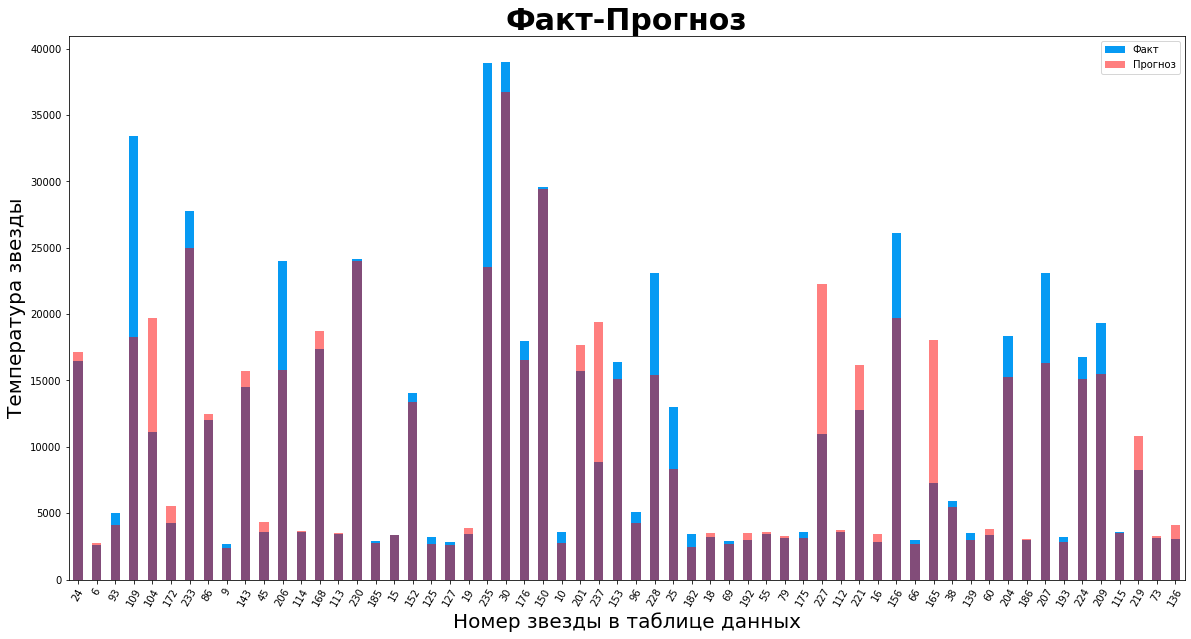

In [86]:
# Строим график факт-прогноз
plt.figure(figsize=(20, 10))
fact_pred['Факт'].plot(kind='bar', color='#069AF3')
fact_pred['Прогноз'].plot(kind='bar', color='red', alpha=0.5)
plt.legend(frameon=True)
plt.xticks(rotation=60)
plt.xlabel('Номер звезды в таблице данных', fontsize=20)
plt.ylabel('Температура звезды', fontsize=20)
plt.title('Факт-Прогноз', fontsize=30, fontweight='bold');

Сведем результаты двух нейросетей в таблицу, для лучшего их сравнения.

**Модель** | **Метрика RMSE** | **Количество эпох** | **Удовлетворяет условиям** | **Количество сильно отличающихся точек** |
:------------- | :-------------: | :-----------: | :------------: | :-----------: |
**Baseline** | 11818 |   200 |  ❌ | 15 |
**ImprovedBaseline** | 4497 | 1000 |  ✅  | 10|
 Разница, %| 61.95 | 800 | 100 | 35|
 
 В результате видно, что по всем показателям улчшение нейронной сети пошло на пользу.

## Выводы

Данные были получены из файла:

`6_class.csv`

Сначала был сделан обзор данных. Само исследование проходило в 6 этапов:

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных к построению модели
5. Построение базовой нейронной сети
6. Улучшение нейронной сети
7. Общий вывод

**1. Изучение данных**

Загрузили файл и сохранили его в переменной `star_df`. Далее изучили данные, используя `info`, `describe`

Всего в таблице 6 столбцов, тип данных - `float`(3), `int`(2) и `object`(1). Количество значений в столбцах одинаковые, а вероятно пропусков нет.

Исходя из описательной статистики заметили, что у признаков сильно отличаются значения медианы и среднего. Предположили два варианта либо же в данных присутствуют выбросы, либо же данные просто не стандартизированы.

По итогу первого пункта были намечены действия для следующего.

**2. Предобработка данных**

По итогу данного этапа были сделаны действия намеченные в прошлом этапе:

- Изменили тип данных в столбцах для экономичного управления памятью
- Изменили названия столбцов для удобства
- Изменили тип данных в столбцах `color` и `type` на `category`
- Сделали проверку на пропуски в данных. В результате не обнаружены.
- Сделали проверку на явные дубликаты. В результате не обнаружены.
- Сделали проверку на неявные дубликаты и исправили. Были найдены несколько неявных дубликатов в цветах звезд. Привели цвета к нижнему регистру и удалили пробелы, тем самым исправили часть дубликатов. Затем пришлось изменить несколько названий одних и тех же цветов.
    - blue white на blue-white.
    - white-yellow на yellow-white.
- Цвета pale yellow orange, orange и orange-red объединили в один цвет `orange` из-за малого количества их по отдельности.

**3. Исследовательский анализ данных**

Далее мы приступили к исследованию данных и оно проходило в два этапа:

- Анализ категориальных данных.
- Анализ количественных данных.

*Для категориальных данных (цвет и тип) построили круговую диаграмму (`pie`) и `barplot`:*

В результате в данных преобладают звезды трех цветов: `red` - 47.9%, `blue` - 32.1% и `white` - 10.8%. Первые два цвета составляют 80% данных. Все остальные цвета незначительные. Самые редкие цвета - `yellowish white` - 1.7%, `yellowish` - 2.1% и `orange` - 2.5%.

По типу звезд данные имеют одинаковое соотношение - 16.7%

*Для количественных данных:*

Были построены диаграммы рассеяния и гистограммы распределений. По итогу их изучения, как и предполагалось ранее (по описательной статистике) были найдены редкие выбивающиеся значения, поэтому сделали упор эти значения. В трех столбцах такие значения были найдены. В результате был проведен более детальный анализ. По итогу все выбивающиеся значения не посчитали аномальными, так как эти редкие значения соответствуют редким звездам (огромным, ярким и т.п.) и такие звезды меньше изучены, отсюда и редкость. 

Также во время обучения отметили для себя, что на основе столбцов `radius` и `luminosity` можно создать новые категории, так как данные очень хорошо распределены на отдельные кластеры (для этого построили график Pair-plot). Все количественные признаки распределены ненормально, что также было проверено с помощью статистического теста Шапиро-Уилка и графика QQ-plot.

**4. Подготовка данных к построению модели**

Для подготовки данных заменили названия цветов цифрами, как сделано в столбце тип звезды.

Чтобы сохранить редкие значения было принято решение создать два новых столбца `radius_cat` и `luminosity_cat`.

Новый столбец по радиусу включал в себя две категории, если радиус < 250 то это будет `small` в противном случае `large`.

Новый столбец по светимости включал в себя три категории, если светимость < 100000 то это будет `faintly bright`, больше 500000 то `Very bright` и в противном случае `bright`.

Далее создали еще несколько новых столбцов, в которых за основу взяли метод `pd.factorize` и объединили радиус, светимость и магнитуду с типом звезды и ее цветом. В результате у нас получилось 6 новых признаков.

И чтобы внести в данные нелинейность решили прологарифмировать наши количественные столбцы и создать на их основе новые столбцы. Для магнитуды возьмем значения по модулю, так как в нем пресутсвуют отрицательные значения, а следовательно логарифм взять не получить.

Затем подготовили тренировочную и тестовую выборки. Целевой признак - `temperature`. Сделали масштабирование количественных данных методом `StandardScaler`, категориальные данные закодировали при помощи `OneHotEncoder` и затем перевели данные в тензор.

**5. Построение базовой нейронной сети**

Было перепробовано множество различных комбинаций скрытых слоев, количества нейронов в них и функций активаций. По итогу остановились на 2 скрытых слоях с 27 и 13 нейронами. Функция активации `ReLU`. Оценивали модель по метрике `RMSE` < 4500. Целевой признак температура (столбец temperature). 

Был cоздан класс архитектуры нейронной сети `StarNet` и написана функция `baseline` для обучения. Количество эпох - 1000. По итогу лучшее значение метрики `RMSE` было на 200 эпохе и составляло 11818. И был построен график "Факт-Прогноз".

Было ясно, что такой результат вообще не удовлетворяет условиям задачи, поэтому необходимо улучшить нашу базовую модель.

**6. Улучшение нейронной сети**

Улучшать нейронную сеть решили при помощи перебора ее параметров. Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации и количество эпох — оставили как в `Baseline`, чтобы в дальнейшим сравнить их. Параметры для перебора:

- Размер батча
- Dropout

Также был создан новый класс архитектуры нейронной сети. И написаны две функции для обучения модели и для оценки модели на тестовой выборке. В результате получили `RMSE` - 4497 при параметрах нейросети:

- Размер батча - 40
- Dropout - 0.4

В конце также был построен график "Факт-Прогноз"

**Вывод**

Были обучены две нейронных сети. Результат сравнения сведен в таблицу.

**Модель** | **Метрика RMSE** | **Количество эпох** | **Удовлетворяет условиям** | **Количество сильно отличающихся точек** |
:------------- | :-------------: | :-----------: | :------------: | :-----------: |
**Baseline** | 11818 |   200 |  ❌ | 15 |
**ImprovedBaseline** | 4497 | 1000 |  ✅  | 10|
 Разница, %| 61.95 | 800 | 100 | 35|
 
Достоинство работы заключается в том, что было достигнуто необходимое условие по метрике `RMSE`

Недостатки работы в том, что метрика близка к минимально возможной. Так же видно, что модель плохо предсказывает температуру редких звезд.

Как можно улучшить работу? Добиться уменьшения метрики, стоит добавить еще больше нелинейности в данные, либо увеличить количество скрытых слоев, либо же попытаться синтезировать значения, чтобы было больше данных для обучения.